In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import muon_data, pileup_data, muon_data_split, pileup_data_split, \
                    mix_training_inputs

from nn_models import create_model, create_model_bn, \
                      create_model_sequential, create_model_sequential_regularized, \
                      lr_decay, modelbestcheck, modelbestcheck_weights

from nn_training import train_model, train_model_sequential

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.19.2


In [2]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.3)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.16.npz ...
[INFO    ] Loaded the variables with shape (3312660, 87)
[INFO    ] Loaded the parameters with shape (3312660, 3)
[INFO    ] Loaded # of training and testing events: (2318862, 993798)


In [3]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=30)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.zeros((pu_x_train.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.zeros((pu_x_test.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd.16.npz ...
[INFO    ] Loaded the variables with shape (351553, 87)
[INFO    ] Loaded the auxiliary PU info with shape (351553, 4)
[INFO    ] Loaded # of training and testing events: (169628, 181925)


In [4]:
# Create models
# model_seq is a densely connected NN with 3 hidden layers and 1 output node
# model is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

model_seq = create_model_sequential(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg)

#model_seq = create_model_sequential_regularized(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg)

model = create_model(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                     nodes1=48, nodes2=32, nodes3=24)

#model = create_model_bn(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
#                        nodes1=48, nodes2=32, nodes3=24)

### Training

In [5]:
training_seq = False
training_func = False
training_pruned = True

In [6]:
# Training (Sequential)

if training_seq:
  assert(keras.backend.backend() == 'tensorflow')

  history = train_model_sequential(model_seq, x_train, y_train[0] if isinstance(y_train, list) else y_train, 
                                   model_name='model', epochs=200, batch_size=256,
                                   callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [7]:
# Training (Functional)

if training_func:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut)
  else:
    raise Exception('add_noise must be set to True')

  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=100, batch_size=8192,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4637724, 80), y_train_new has shape (4637724,),(4637724,)
[INFO    ] Begin training ...
[INFO    ] Saved model as model.h5, model.json and model_weights.h5
[INFO    ] Done training. Time elapsed: 0:18:17.187870 sec
[INFO    ] Epoch 100/100 - loss: 2.43743293653 - val_loss 2.45676172362


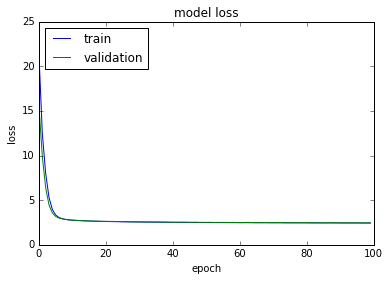

In [8]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=2048)

if training_seq or training_func:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [78]:
# Pruning
# Copied from Javier: https://github.com/hls-fpga-machine-learning/keras-training/blob/muon/train/prune.py

allWeights = []
allWeightsNonRel = []
allWeightsByLayer = {}
allWeightsByLayerNonRel = {}
for layer in model.layers:         
    if layer.__class__.__name__ in ['Dense', 'Conv1D']:
        original_w = layer.get_weights()
        weightsByLayer = []
        weightsByLayerNonRel = []
        for my_weights in original_w:                
            if len(my_weights.shape) < 2: # bias term, ignore for now
                continue
            #l1norm = tf.norm(my_weights,ord=1)
            elif len(my_weights.shape) == 2: # Dense
                tensor_abs = tf.abs(my_weights)
                tensor_reduce_max_1 = tf.reduce_max(tensor_abs,axis=-1)
                tensor_reduce_max_2 = tf.reduce_max(tensor_reduce_max_1,axis=-1)
            elif len(my_weights.shape) == 3: # Conv1D
                # (filter_width, n_inputs, n_filters)
                tensor_abs = tf.abs(my_weights)
                tensor_reduce_max_0 = tf.reduce_max(tensor_abs,axis=-1)
                tensor_reduce_max_1 = tf.reduce_max(tensor_reduce_max_0,axis=-1)
                tensor_reduce_max_2 = tf.reduce_max(tensor_reduce_max_1,axis=-1)
            with tf.Session():
                #l1norm_val = float(l1norm.eval())
                tensor_max = float(tensor_reduce_max_2.eval())
            it = np.nditer(my_weights, flags=['multi_index'], op_flags=['readwrite'])   
            while not it.finished:
                w = it[0]
                allWeights.append(abs(w)/tensor_max)
                allWeightsNonRel.append(abs(w))
                weightsByLayer.append(abs(w)/tensor_max)
                weightsByLayerNonRel.append(abs(w))
                it.iternext()
        if len(weightsByLayer)>0:
            allWeightsByLayer[layer.name] = np.array(weightsByLayer)
            allWeightsByLayerNonRel[layer.name] = np.array(weightsByLayerNonRel)

allWeightsArray = np.array(allWeights)
allWeightsArrayNonRel = np.array(allWeightsNonRel)
print allWeightsByLayer.keys(), allWeightsByLayer
print allWeightsByLayerNonRel.keys(), allWeightsByLayerNonRel

['regr', 'discr', 'dense_7', 'dense_6', 'dense_5'] {'regr': array([0.88102954, 0.95517934, 0.95509061, 0.8322041 , 0.91880222,
       0.92454478, 0.94845847, 0.96073423, 0.97692336, 0.85357674,
       0.82386447, 0.42258571, 0.89519582, 0.95472562, 0.88953003,
       1.        ]), 'discr': array([0.42107124, 0.10173818, 0.05686441, 0.20686352, 0.14788342,
       0.19543047, 0.02495982, 0.30493573, 0.18408566, 0.02626727,
       0.27483836, 1.        , 0.19370966, 0.05036573, 0.36064723,
       0.34268219]), 'dense_7': array([0.38887153, 0.33695745, 0.3154203 , 0.5508642 , 0.55199091,
       0.3450182 , 0.49920797, 0.10827154, 0.20242442, 0.66130465,
       0.46967373, 0.07322558, 0.52834713, 0.15457532, 0.38807379,
       0.48908764, 0.09064716, 0.68099533, 0.20455542, 0.50434973,
       0.34190188, 0.80731075, 0.10064869, 0.3626581 , 0.20670985,
       0.30312016, 0.17166074, 0.12012365, 0.22594437, 0.75126742,
       0.59235724, 0.63419173, 0.07528771, 0.23091277, 0.59515362,
       

In [79]:
relative_weight_max = np.percentile(allWeightsArray,50,axis=-1)

weightsPerLayer = {}
droppedPerLayer = {}
binaryTensorPerLayer = {}
for layer in model.layers:     
    droppedPerLayer[layer.name] = []
    if layer.__class__.__name__ in ['Dense', 'Conv1D']:
        original_w = layer.get_weights()
        weightsPerLayer[layer.name] = original_w
        for my_weights in original_w:
            if len(my_weights.shape) < 2: # bias term, skip for now
                continue
            #l1norm = tf.norm(my_weights,ord=1)
            elif len(my_weights.shape) == 2: # Dense
                tensor_abs = tf.abs(my_weights)
                tensor_reduce_max_1 = tf.reduce_max(tensor_abs,axis=-1)
                tensor_reduce_max_2 = tf.reduce_max(tensor_reduce_max_1,axis=-1)
            elif len(my_weights.shape) == 3: # Conv1D
                tensor_abs = tf.abs(my_weights)
                tensor_reduce_max_0 = tf.reduce_max(tensor_abs,axis=-1)
                tensor_reduce_max_1 = tf.reduce_max(tensor_reduce_max_0,axis=-1)
                tensor_reduce_max_2 = tf.reduce_max(tensor_reduce_max_1,axis=-1)
            with tf.Session():
                #l1norm_val = float(l1norm.eval())
                tensor_max = float(tensor_reduce_max_2.eval())
            it = np.nditer(my_weights, flags=['multi_index'], op_flags=['readwrite'])
            binaryTensorPerLayer[layer.name] = np.ones(my_weights.shape)
            while not it.finished:
                w = it[0]
                if abs(w)/tensor_max < relative_weight_max:
                    #print "small relative weight %e/%e = %e -> 0"%(abs(w), tensor_max, abs(w)/tensor_max)
                    w[...] = 0
                    droppedPerLayer[layer.name].append((it.multi_index, abs(w)))
                    binaryTensorPerLayer[layer.name][it.multi_index] = 0
                it.iternext()
        #print '%i weights dropped from %s out of %i weights'%(len(droppedPerLayer[layer.name]),layer.name,layer.count_params())
        #converted_w = convert_kernel(original_w)
        #converted_w = original_w
        #layer.set_weights(converted_w)

print 'Summary:'
totalDropped = sum([len(droppedPerLayer[layer.name]) for layer in model.layers])
for layer in model.layers:
    print '%i weights dropped from %s out of %i weights'%(len(droppedPerLayer[layer.name]),layer.name, layer.count_params())
print '%i total weights dropped out of %i total weights'%(totalDropped,model.count_params())
print '%.1f%% compression'%(100.*totalDropped/model.count_params())

Summary:
0 weights dropped from input_1 out of 0 weights
3532 weights dropped from dense_5 out of 5184 weights
285 weights dropped from dense_6 out of 2080 weights
39 weights dropped from dense_7 out of 528 weights
0 weights dropped from regr out of 17 weights
0 weights dropped from discr out of 17 weights
3856 total weights dropped out of 7826 total weights
49.3% compression


In [80]:
from keras.constraints import *
from keras.layers.merge import multiply
from keras import constraints

class ZeroSomeWeights(Constraint):
    """ZeroSomeWeights weight constraint.
    Constrains certain weights incident to each hidden unit
    to be zero.
    # Arguments
        binary_tensor: binary tensor of 0 or 1s corresponding to which weights to zero.
    """

    def __init__(self, binary_tensor=None):
        self.binary_tensor = binary_tensor

    def __call__(self, w):
        if self.binary_tensor is not None:
            w = multiply([w,  K.variable(value=self.binary_tensor)])
        return w

    def get_config(self):
        config = {'binary_tensor': constraints.serialize(self.binary_tensor)}
        return config

# Aliases.

zero_some_weights = ZeroSomeWeights

In [85]:
from nn_models import *

def create_model_pruned(nvariables, lr=0.001, nodes1=64, nodes2=32, nodes3=16, discr_loss_weight=1.0, l1_reg=0.0, l2_reg=0.0):
  regularizer = regularizers.l1_l2(l1=0.0, l2=0.0)  # disable
  constraint_dense_5 = zero_some_weights(binary_tensor=binaryTensorPerLayer['dense_5'])
  constraint_dense_6 = zero_some_weights(binary_tensor=binaryTensorPerLayer['dense_6'])
  constraint_dense_7 = zero_some_weights(binary_tensor=binaryTensorPerLayer['dense_7'])
  
  inputs = Input(shape=(nvariables,), dtype='float32')

  x = Dense(nodes1, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, kernel_constraint=constraint_dense_5)(inputs)
  #x = Dropout(0.2)(x)
  if nodes2 > 0:
    x = Dense(nodes2, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, kernel_constraint=constraint_dense_6)(x)
    #x = Dropout(0.2)(x)
    if nodes3 > 0:
      x = Dense(nodes3, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizer, kernel_constraint=constraint_dense_7)(x)
      #x = Dropout(0.2)(x)

  regr = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='regr')(x)
  discr = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform', name='discr')(x)

  # This creates a model that includes
  # the Input layer, three Dense layers and the Output layer
  model = Model(inputs=inputs, outputs=[regr, discr])

  # Set loss and optimizers
  #binary_crossentropy = losses.binary_crossentropy
  #mean_squared_error = losses.mean_squared_error

  adam = optimizers.Adam(lr=lr)
  model.compile(optimizer=adam,
    loss={'regr': masked_huber_loss, 'discr': masked_binary_crossentropy},
    loss_weights={'regr': 1.0, 'discr': discr_loss_weight},
    #metrics={'regr': ['acc', 'mse', 'mae'], 'discr': ['acc',]}
    )
  return model

In [86]:
model_unpruned = model
model_pruned = create_model_pruned(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight)
model = model_pruned

In [87]:
if training_func:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut)
  else:
    raise Exception('add_noise must be set to True')

  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=100, batch_size=8192,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4637724, 80), y_train_new has shape (4637724,),(4637724,)
[INFO    ] Begin training ...


ValueError: can only convert an array of size 1 to a Python scalar

In [105]:
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"ZeroSomeWeights": ZeroSomeWeights})

model_config = model._updated_config()

def get_json_type(obj):
    if hasattr(obj, 'get_config'):
        return {'class_name': obj.__class__.__name__,
                'config': obj.get_config()}

    # if obj is any numpy type
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()

    # misc functions (e.g. loss function)
    if callable(obj):
        return obj.__name__

    # if obj is a python 'type'
    if type(obj).__name__ == type.__name__:
        return obj.__name__

    raise TypeError('Not JSON Serializable:', obj)

import json
json.dumps(model_config, default=get_json_type)

#save_my_model(model, name='model_pruned')

'{"class_name": "Model", "keras_version": "2.1.4", "config": {"layers": [{"class_name": "InputLayer", "config": {"dtype": "float32", "batch_input_shape": [null, 80], "name": "input_3", "sparse": false}, "inbound_nodes": [], "name": "input_3"}, {"class_name": "Dense", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "dense_11", "kernel_constraint": {"class_name": "ZeroSomeWeights", "config": {"binary_tensor": [[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1

### Regression Results

In [106]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')
eps = 1e-4
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

# Setup Gaussian fit
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
  return 0.5*a*np.exp(-np.square((x-x0)/sigma))

def fit_gaus(hist, edges, mu=0., sig=1.):
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  return popt

In [110]:
# Load model and predict outputs
from nn_models import load_my_model
#loaded_model = load_my_model(name='model', weights_name='model_weights')
loaded_model = model  ##FIXME

nentries_test = x_test.shape[0]//4

# Prepare x_test_ndof
x_test_ndof = (x_mask_test[:nentries_test] == False).sum(axis=1)
#print x_test_ndof.shape, x_test_ndof

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] # of entries: 248449, mean: 0.000501767033711, std: 0.0331856459379
[INFO    ] gaus fit (a, mu, sig): [5.23052265e+04 1.32091934e-04 2.85855558e-02]


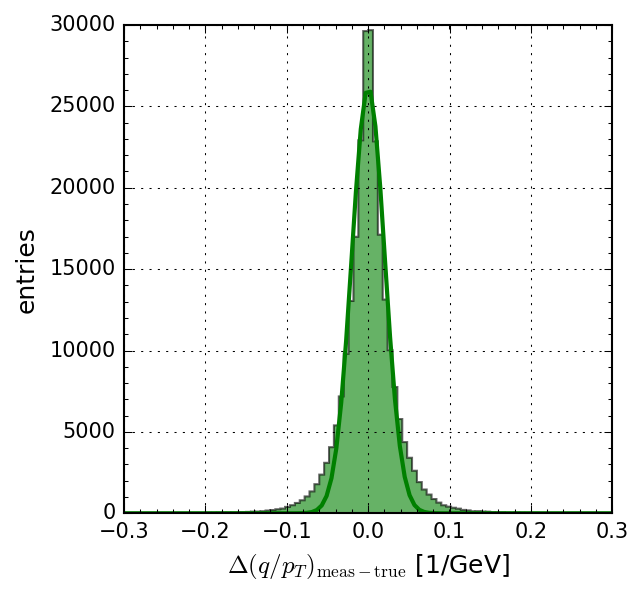

In [111]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

[INFO    ] # of entries: 248449, mean: 0.237596347928, std: 0.207076758146
[INFO    ] gaus fit (a, mu, sig): [ 6.27452787e+04 -9.16594183e-03  1.62016211e-01]


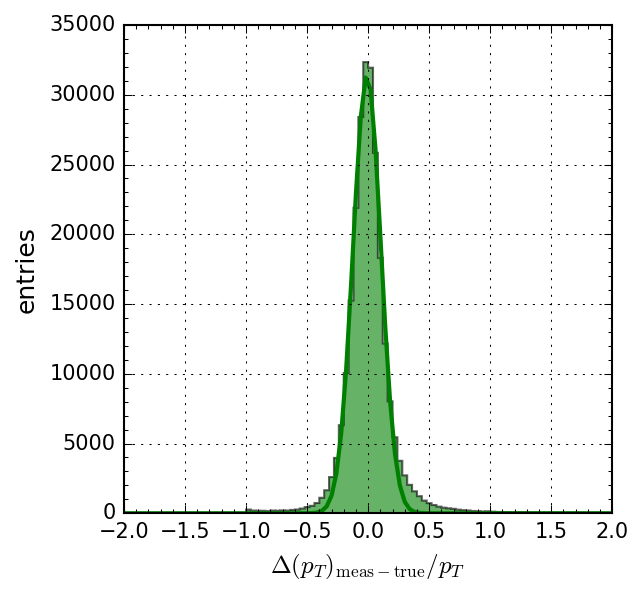

In [112]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

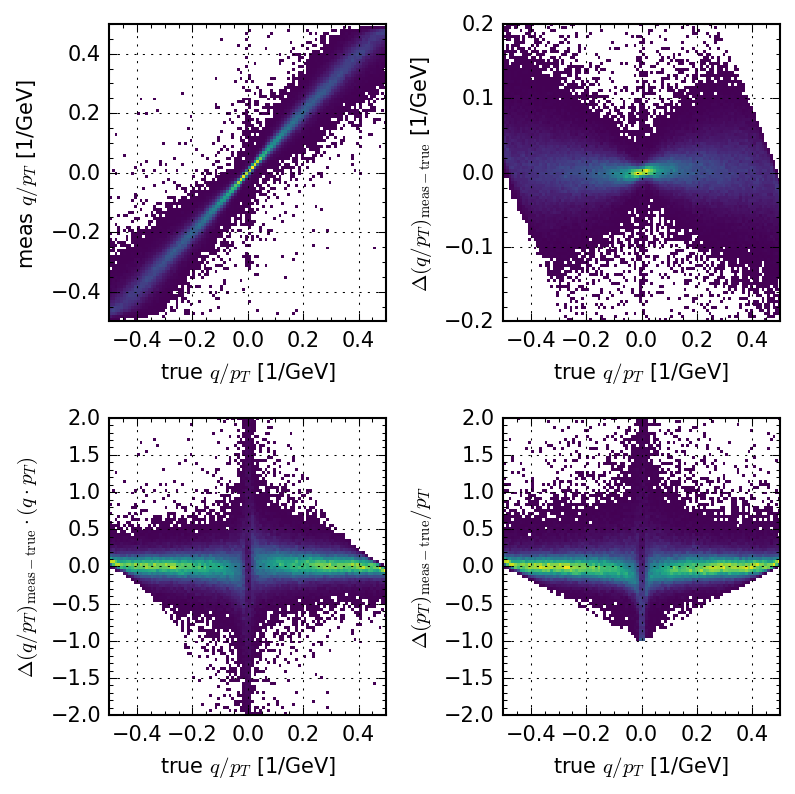

In [113]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [114]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[np.abs(yy_i) < 2]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 4.89457267e+02 -5.78448768e-02  2.43728628e-01]


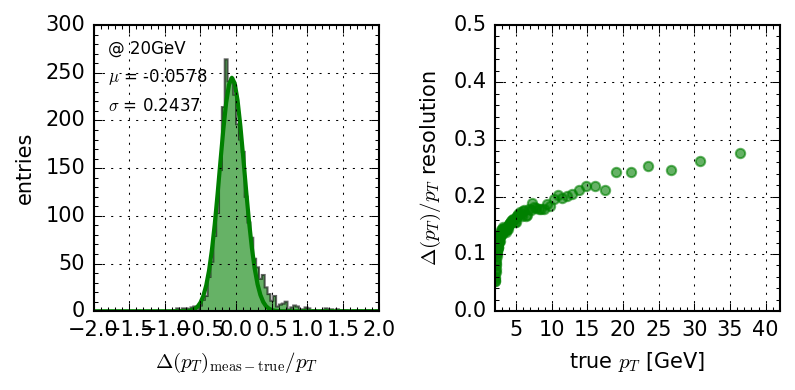

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=np.mean(yy_20GeV), sig=np.std(yy_20GeV[np.abs(yy_20GeV)<1.5]))
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(2,42)
axs[1].set_ylim(0,0.5)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)

plt.show()

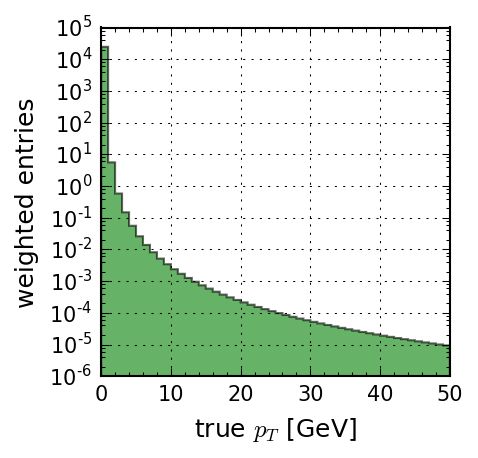

In [116]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [117]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 15.5902481079 rate 130.939147949
[INFO    ] 22 GeV threshold 16.7212848663 rate 108.386184692


In [118]:
# Use the predicted rate as loss function/scoring in training
if True:
  from nn_models import NewKerasRegressor
  estimator = NewKerasRegressor(build_fn=create_model_sequential, reg_pt_scale=reg_pt_scale, min_pt=20., max_pt=22., coverage=90.,
                                nvariables=nvariables, lr=learning_rate)

  estimator.model = loaded_model

  # Cross check
  print estimator.score(x_test[:nentries_test], y_test[0][:nentries_test] if isinstance(y_test, list) else y_test)

-130.93915


### Classification Results

In [119]:
# Prepare pu_x_test_ndof
pu_x_test_ndof = (pu_x_mask_test == False).sum(axis=1)
#print pu_x_test_ndof.shape, pu_x_test_ndof

# Prepare y_test_true, y_test_meas
y_test_true = [y_test[0][:nentries_test, np.newaxis].copy(), y_test[1][:nentries_test, np.newaxis].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true = [y_test_true[0], y_test_true[1]]
y_test_meas = [y_test_meas[0], y_test_meas[1]]
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=2048)
pu_y_test_meas = [pu_y_test_meas[0].reshape(-1), pu_y_test_meas[1].reshape(-1)]
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

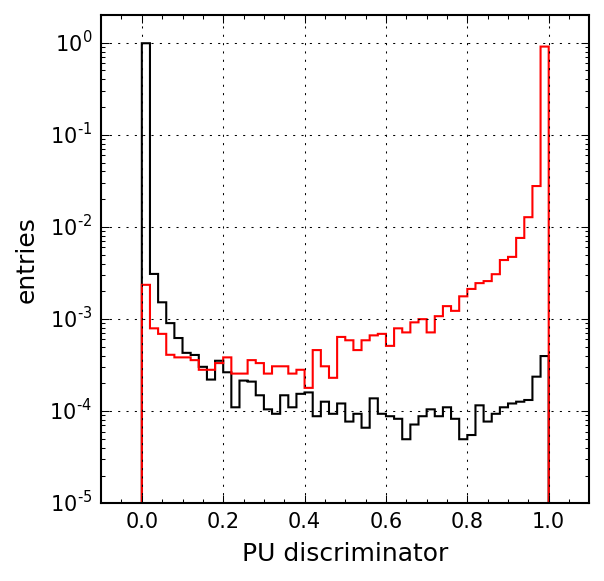

In [120]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black')
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red')
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

[INFO    ] auc: 0.996113728079
[INFO    ] thr: [0.9924, 0.9881, 0.9797, 0.9634, 0.9425, 0.9213, 0.8830, 0.7739, 0.2885]
[INFO    ] tpr: [0.9016, 0.9270, 0.9527, 0.9711, 0.9806, 0.9855, 0.9901, 0.9951, 0.9990]
[INFO    ] fpr: [0.0095, 0.0111, 0.0157, 0.0229, 0.0255, 0.0304, 0.0356, 0.0451, 0.0768]


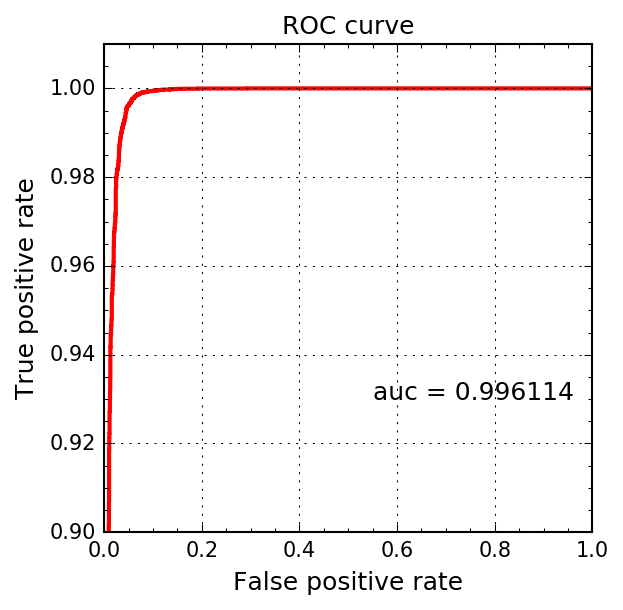

In [121]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))

zz_tmp = np.abs(1.0/zz) > discr_pt_cut
xx = xx[zz_tmp]
yy = yy[zz_tmp]

fpr, tpr, thresh = roc_curve(xx, yy)  # (y_true, y_meas)
auc = roc_auc_score(xx, yy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.55, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,1.0)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [122]:
# Build a trigger object

pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - abs(ipt - best_ipt)

class MyTrigger(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8119,  1.5341,  1.5840,  1.8355,  2.2079,  2.6573,  3.1669,  3.7199,
                  4.3017,  4.9048,  5.5273,  6.1663,  6.8168,  7.4742,  8.1347,  8.8046,
                  9.4860, 10.1795, 10.8819, 11.5959, 12.3331, 13.0830, 13.8191, 14.5403,
                 15.2607, 16.0057, 16.7717, 17.5494, 18.3334, 19.1061, 19.8733, 20.6527,
                 21.4504, 22.2787, 23.0876, 23.8056, 24.4518, 25.1024, 25.8266, 26.6499,
                 27.4875, 28.3035, 29.1329, 30.0344, 30.9851, 31.8599, 32.6693, 33.5131,
                 34.4069, 35.2728, 36.0266, 36.7357, 37.5070, 38.4116, 39.3509, 40.2445,
                 41.1330, 42.0454, 43.0473, 44.1787, 45.3398, 46.4555, 47.6894, 49.1895,
                 50.4369, 51.3839, 52.2270, 53.0509, 53.8703, 54.6880, 55.5049, 56.3214,
                 57.1376, 57.9536, 58.7695, 59.5853, 60.4011, 61.2168, 62.0325, 62.8481,
                 63.6638, 64.4794, 65.2951, 66.1107, 66.9263, 67.7419, 68.5575, 69.3731,
                 70.1887, 71.0042, 71.8198, 72.6354, 73.4510, 74.2666, 75.0821, 75.8977,
                 76.7133, 77.5288, 78.3444, 79.1600, 79.9756, 80.7911, 81.6067, 82.4223,
                 83.2378, 84.0534, 84.8690, 85.6845, 86.5001, 87.3157, 88.1312, 88.9468,
                 89.7624, 90.5779, 91.3935, 92.2091, 93.0246, 93.8402, 94.6558, 95.4714]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]

  def get_trigger_pt(self, x, y_meas):
    #zone = int(x[(nlayers*6) + 1] * 5)

    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-8)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return int(binx)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if (binx+1) >= self.s_nbins:  # check boundary
      binx = self.s_nbins-2

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, x, ndof, y_meas, y_discr, discr_pt_cut=14.):
    trk_mode = 0
    x_mode_vars = np.equal(x[nlayers*6+3:nlayers*6+8], 1)
    for i, x_mode_var in enumerate(x_mode_vars):
      if i == 0:
        station = 1
      else:
        station = i
      if x_mode_var:
        trk_mode |= (1 << (4 - station))

    straightness = int(x[(nlayers*6) + 0] * 6) + 6

    ipt1 = straightness
    ipt2 = find_pt_bin(y_meas)
    quality1 = emtf_road_quality(ipt1)
    quality2 = emtf_road_quality(ipt2)

    if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > discr_pt_cut:
        if ndof <= 3:
          #trigger = (y_discr > 0.8)
          trigger = (y_discr > 0.9928)  # 95% coverage
          #trigger = (y_discr > 0.9999)  # 95% coverage
        else:
          #trigger = (y_discr > 0.5393)
          trigger = (y_discr > 0.9458) # 98.5% coverage
          #trigger = (y_discr > 0.9929) # 99% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

mytrigger = MyTrigger()

In [123]:
# Efficiency
eff_data = []

for x, ndof, y_meas, y_discr, y_true in zip(x_test, x_test_ndof, y_test_meas[0], y_test_meas[1], y_test_true[0]):
  zone = int(x[(nlayers*6) + 1] * 5)
  
  passed = mytrigger.pass_trigger(x, ndof, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed))

eff_data = np.asarray(eff_data)
print eff_data.shape, eff_data

(248449, 5) [[3.         4.06132793 4.9887805  5.51333141 1.        ]
 [3.         2.57501101 2.4849298  2.64375496 1.        ]
 [1.         2.55024886 2.36458087 2.5355854  1.        ]
 ...
 [3.         6.10882711 5.76867199 6.51584196 1.        ]
 [2.         4.21373606 4.33278656 4.70310736 1.        ]
 [0.         6.54953098 6.23594427 7.12701988 1.        ]]


10.0 [           nan            nan            nan 2.12381863e-04
 8.28704533e-04 3.60144058e-03 1.25545852e-02 1.08990414e-01
 5.81856025e-01 9.06468717e-01 9.59180506e-01 9.54314721e-01
 9.62798009e-01 9.63085036e-01 9.66782542e-01 9.69785575e-01
 9.73570020e-01 9.79024390e-01 9.74694984e-01 9.72027972e-01
 9.73104056e-01 9.68680089e-01 9.66884532e-01 9.65879265e-01]
20.0 [           nan            nan            nan 4.55103991e-05
 1.11987099e-04 2.91025501e-04 1.47379913e-03 3.32498489e-03
 1.05504916e-02 4.19936373e-02 1.45273941e-01 3.81928934e-01
 6.46319099e-01 8.14106790e-01 8.94940131e-01 9.32261209e-01
 9.57396450e-01 9.67317073e-01 9.66109354e-01 9.65446318e-01
 9.66931217e-01 9.66890380e-01 9.62091503e-01 9.59317585e-01]
30.0 [           nan            nan            nan 1.51701330e-05
 6.71922595e-05 7.27563753e-05 8.73362445e-04 1.68408325e-03
 3.22974234e-03 7.52916225e-03 1.36582337e-02 4.83248731e-02
 9.43149070e-02 2.05339486e-01 3.59598301e-01 5.19980507e-01
 6.8047

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


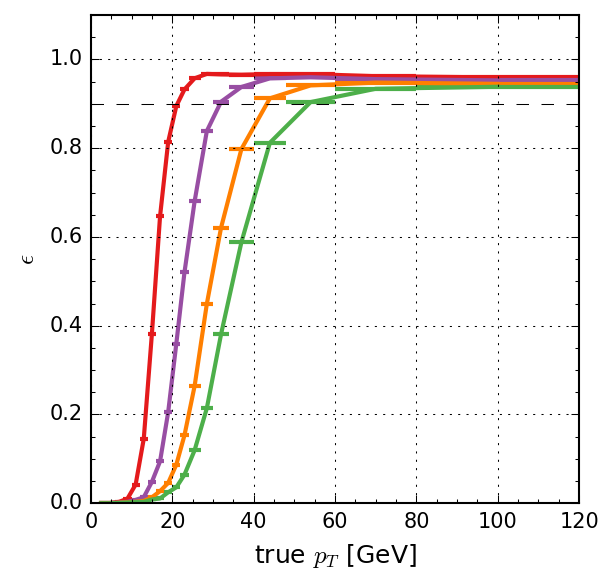

In [124]:
# Efficiency
eff_pt_bins = (0., 0.5, 1., 2., 3., 4., 5., 6., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

denom_hist, edges = np.histogram(eff_data[:, 1], bins=eff_pt_bins)

plt.figure()
pt_list = (10., 20., 30., 40., 50., 60.)

for pt, color in zip(pt_list, my_palette):
  passed = (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)
  eff_hist = np.true_divide(num_hist, denom_hist)
  print pt, eff_hist

  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = 0  #FIXME: get error bars
  ydata = eff_hist
  if pt == 10.:
    pass
  else:
    plt.errorbar(xdata, ydata, xerr=xerr, color=color, marker=',', capsize=0)

plt.plot(eff_pt_bins, np.ones_like(eff_pt_bins)*0.9, ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [125]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((4,nbinsx), dtype=np.float32)

for j in xrange(4):  # j = zone0-1, zone2-3, zone4-5, all zones
  if j == 3:
    eff_data_tmp = (eff_data[:,0] >= 0)
  else:
    eff_data_tmp = (eff_data[:,0] == 2*j) | (eff_data[:,0] == 2*j+1)
  xx = eff_data[:,1][eff_data_tmp]
  yy = eff_data[:,2][eff_data_tmp]
  zz = eff_data[:,4][eff_data_tmp]
  
  inds = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= inds) & (inds <= i+step)]
    yy_i = yy[(i <= inds) & (inds <= i+step)]
    zz_i = zz[(i <= inds) & (inds <= i+step)]
    coverage = 90  
    coverage += 2.5 # inefficiency due to fiducial cuts
    #coverage += 100. * (zz_i==0).sum() / (zz_i>=0).sum()  # inefficiency due to PU discr
    pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    # Debug
    if j == 3 and xedges[i] > discr_pt_cut:
      print i, xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    
    xxx[j,i] = pct

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

29 14.5 3.35115864528
30 15.0 3.34156066072
31 15.5 3.16944331573
32 16.0 3.19585402721
33 16.5 3.24042601405
34 17.0 3.19634703196
35 17.5 3.10097385956
36 18.0 3.12750601443
37 18.5 2.97920179876
38 19.0 2.84207442133
39 19.5 2.69525267994
40 20.0 2.70614453996
41 20.5 2.57783729494
42 21.0 2.43300423131
43 21.5 2.58260539309
44 22.0 2.56
45 22.5 2.3680930619
46 23.0 2.4295010846
47 23.5 2.62338817252
48 24.0 2.35674676525
49 24.5 2.02221589291
50 25.0 1.9305019305
51 25.5 1.85931205454
52 26.0 1.70692431562
53 26.5 1.75496688742
54 27.0 1.94871794872
55 27.5 1.89015691869
56 28.0 1.91669738297
57 28.5 1.82857142857
58 29.0 1.82879377432
59 29.5 1.98098256735
60 30.0 2.03748981255
61 30.5 2.09731543624
62 31.0 2.0145735105
63 31.5 1.99468085106
64 32.0 2.1719038817
65 32.5 2.023020579
66 33.0 2.12306585103
67 33.5 2.2962962963
68 34.0 2.39289849479
69 34.5 2.35059760956
70 35.0 2.39669421488
71 35.5 2.34441602728
72 36.0 2.28370663153
73 36.5 2.19858156028
74 37.0 2.09251101322
75 37

[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

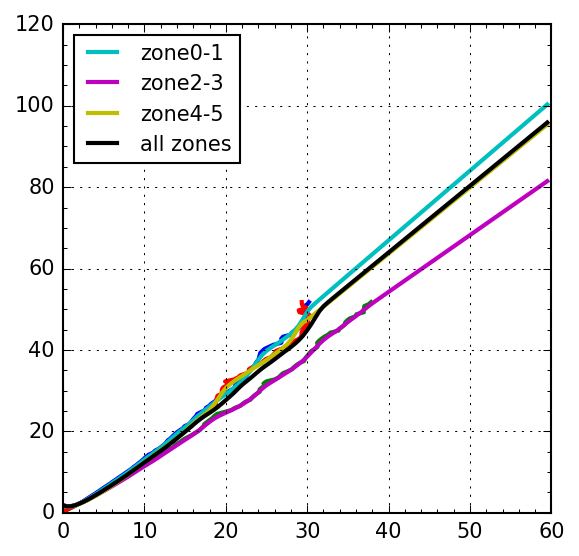

In [126]:
if True:
  plt.figure()
  xdata = (xedges[1:] + xedges[:-1])/2
  plt.plot(xxx[0,:-16], xdata[:-16])
  plt.plot(xxx[1,:-16], xdata[:-16])
  plt.plot(xxx[2,:-16], xdata[:-16])
  #plt.plot(xxx[3,:-16], xdata[:-16])

  from scipy.interpolate import Rbf
  rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

  xdata = xedges[:-1]
  ydata0 = rbf0(xdata)
  ydata1 = rbf1(xdata)
  ydata2 = rbf2(xdata)
  ydata3 = rbf3(xdata)
  
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  
  print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
  print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
  
  plt.legend((line0, line1, line2, line3), ('zone0-1', 'zone2-3', 'zone4-5', 'all zones'), loc='upper left')
  plt.show()

In [127]:
# Rates
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for x, ndof, y_meas, y_discr, aux in zip(pu_x_test, pu_x_test_ndof, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test):
  zone = int(x[(nlayers*6) + 1] * 5)
  
  passed = mytrigger.pass_trigger(x, ndof, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid)
  ievt = int(ievt)
  
  if jobid < (rates_njobs-1):
    if passed:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_job = 31
  if jobid == test_job and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(*aux), ndof, pt, y_discr

  31 2826 19.5646 30.0000 6 29.719776454593884 0.9993808
  31 2937 11.6057 19.5000 6 50.703879994056386 0.9994295
  31 3675  3.0667  8.5000 5 30.15501783250219 0.9923753
  31 4581  1.5532 24.0000 4 25.96342524786619 0.96496004


[INFO    ] nevents: 258400/498400


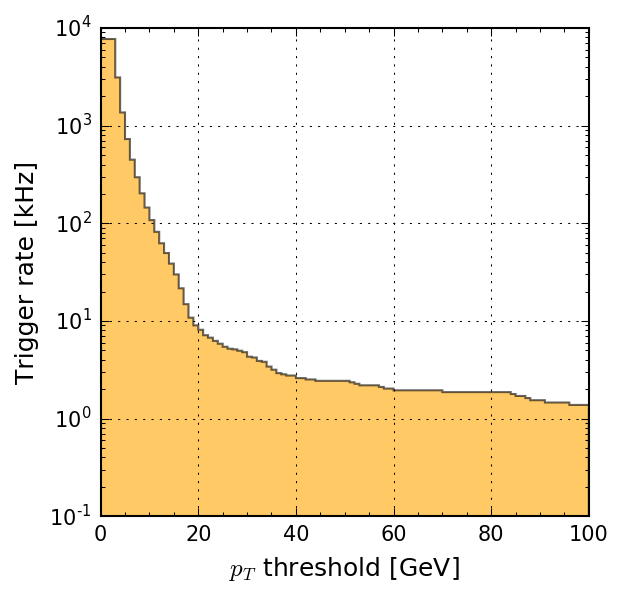

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 10.8007371873, 9.01414899528, 8.12085495889, 7.14635239542, 6.74030964077


[7.71400044e+03 7.71400044e+03 7.71400044e+03 3.11548481e+03
 1.36535932e+03 7.29577585e+02 4.48271189e+02 2.96248789e+02
 2.02777750e+02 1.45038469e+02 1.07844953e+02 8.17770098e+01
 6.24493750e+01 4.96184242e+01 3.86552704e+01 2.99659555e+01
 2.16014746e+01 1.48611649e+01 1.08007372e+01 9.01414900e+00
 8.12085496e+00 7.14635240e+00 6.74030964e+00 6.25305833e+00
 5.84701557e+00 5.44097282e+00 5.19734718e+00 5.11613863e+00
 4.95372153e+00 4.79130443e+00 4.30405315e+00 4.22284460e+00
 3.89801040e+00 3.81680185e+00 3.41075910e+00 3.16713346e+00
 2.92350782e+00 2.84229927e+00 2.76109072e+00 2.76109072e+00
 2.59867362e+00 2.59867362e+00 2.51746507e+00 2.51746507e+00
 2.43625652e+00 2.43625652e+00 2.43625652e+00 2.43625652e+00
 2.43625652e+00 2.43625652e+00 2.43625652e+00 2.35504797e+00
 2.27383942e+00 2.19263087e+00 2.19263087e+00 2.19263087e+00
 2.19263087e+00 2.11142232e+00 2.03021377e+00 2.03021377e+00
 1.94900522e+00 1.94900522e+00 1.94900522e+00 1.94900522e+00
 1.94900522e+00 1.949005

In [128]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11245.6
  nCollBunches = 1866
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
weights = np.zeros_like(rates) + conversion_to_kHz(rates_nevents_1)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', alpha=0.6)
#print hist, edges
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print hist

In [29]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [30]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    
    nentries_test = 100000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1) or lay in (11,):  # ME1/1, ME1/2, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (2,) or lay in (5,6) or lay in (9,10):  # ME2, RE1, RE2, GE1/1, GE2/1
          coef = 1.0/np.std(x_i)
        else:  # ME3, ME4, RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
    
      ## x_time
      #elif (nlayers*3) <= i < (nlayers*4):
      #  coef = 1.0/np.std(x_i)
      #  print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef  

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [31]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()